In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
import pickle

import cycler
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path

from zxreinforce.plot_utils import plot_action_hist

2024-05-15 14:58:23.332155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 14:58:26.697643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_mean_std_nice(x_axis, y_list, label_list = None, ylim=(None, None), xlim=(None, None), 
                       title="", x_label="global step", ylabel="", max_idx=None):
    if not label_list:
        label_list = [""]*len(y_list)
    for i, y in enumerate(y_list):
        if max_idx:
            mean = np.mean([y1[:max_idx] for y1 in y], axis=0)
            std = np.std([y1[:max_idx] for y1 in y], axis=0)
            x_axis_n = x_axis[:max_idx]
        else:
            mean = np.mean(y, axis=0)
            std = np.std(y, axis=0)
            x_axis_n = x_axis
        plt.plot(x_axis_n, mean, label=label_list[i])
        plt.fill_between(x_axis_n, mean - std, mean + std, alpha=0.2)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.grid()
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [3]:
base_path = Path(f"./runs")
all_paths = os.listdir(base_path)

In [4]:
extra_state_info=False
adapted_reward=False
part_path=f"{extra_state_info=}_{adapted_reward=}"
false_false_dirs = [base_path / p / "logs" for p in all_paths if part_path in p]

extra_state_info=False
adapted_reward=True
part_path=f"{extra_state_info=}_{adapted_reward=}"
false_true_dirs = [base_path / p / "logs" for p in all_paths if part_path in p]

extra_state_info=True
adapted_reward=False
part_path=f"{extra_state_info=}_{adapted_reward=}"
true_false_dirs = [base_path / p / "logs" for p in all_paths if part_path in p]

extra_state_info=True
adapted_reward=True
part_path=f"{extra_state_info=}_{adapted_reward=}"
true_true_dirs = [base_path / p / "logs" for p in all_paths if part_path in p]

all_path_list = [true_true_dirs, true_false_dirs, false_true_dirs, false_false_dirs]

In [5]:
max_size=1000

all_value_dicts = []
all_step_dicts = []
for path_list in all_path_list:
    
    value_dicts = []
    step_dicts = []

    for import_path in path_list:

        event_acc = EventAccumulator(str(import_path), size_guidance={"tensors" : max_size})
        event_acc.Reload()

        tracked_values_list = event_acc.Tags()["tensors"]
        value_dict = {}
        step_dict = {}
        for tracked_value in tracked_values_list:
            step_val = np.array([[event.step, tf.make_ndarray(event.tensor_proto)]
                                for event in event_acc.Tensors(tracked_value)])
            step_dict[tracked_value] = step_val[:, 0]
            value_dict[tracked_value] = step_val[:, 1]

        value_dicts.append(value_dict)
        step_dicts.append(step_dict)

    all_value_dicts.append(value_dicts) 
    all_step_dicts.append(step_dicts)  

In [7]:
all_ep_rewards_max_any_mean = np.array([[value_dict["ep_rewards_max_any_mean"] for value_dict in value_dicts] 
                               for value_dicts in all_value_dicts])

In [8]:
x_axis = all_step_dicts[0][0]["ep_rewards_max_any_mean"] - all_step_dicts[0][0]["ep_rewards_max_any_mean"][0]
max_idx = len(all_ep_rewards_max_any_mean[0][0])

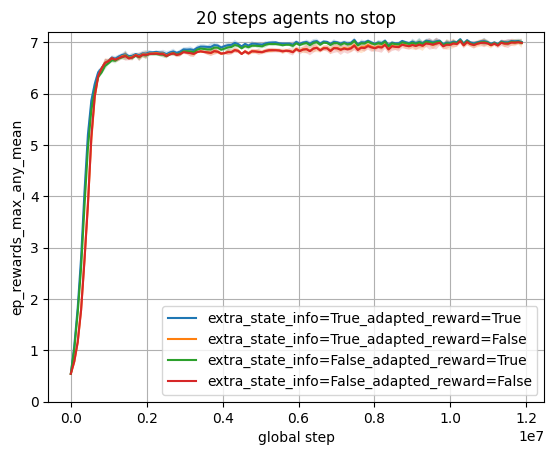

In [9]:
plot_mean_std_nice(x_axis, all_ep_rewards_max_any_mean, 
                   label_list = ["extra_state_info=True_adapted_reward=True", 
                                 "extra_state_info=True_adapted_reward=False", 
                                 "extra_state_info=False_adapted_reward=True", 
                                 "extra_state_info=False_adapted_reward=False"], 
                   ylim=(0, 7.2), 
                   title="20 steps agents no stop", 
                   x_label="global step", 
                   ylabel="ep_rewards_max_any_mean",
                   max_idx=max_idx)

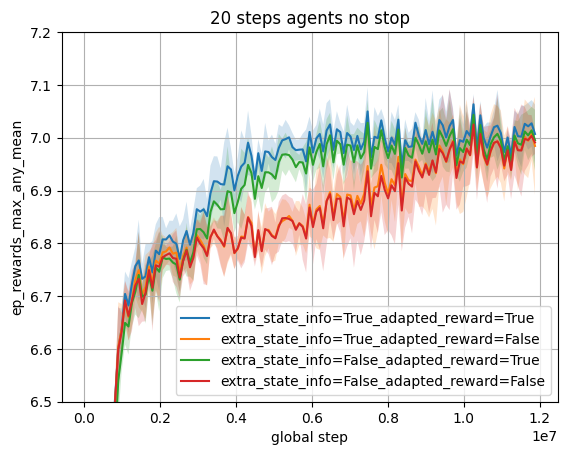

In [10]:
plot_mean_std_nice(x_axis, all_ep_rewards_max_any_mean, 
                   label_list = ["extra_state_info=True_adapted_reward=True", 
                                 "extra_state_info=True_adapted_reward=False", 
                                 "extra_state_info=False_adapted_reward=True", 
                                 "extra_state_info=False_adapted_reward=False"], 
                   ylim=(6.5, 7.2), 
                   title="20 steps agents no stop", 
                   x_label="global step", 
                   ylabel="ep_rewards_max_any_mean",
                   max_idx=max_idx)

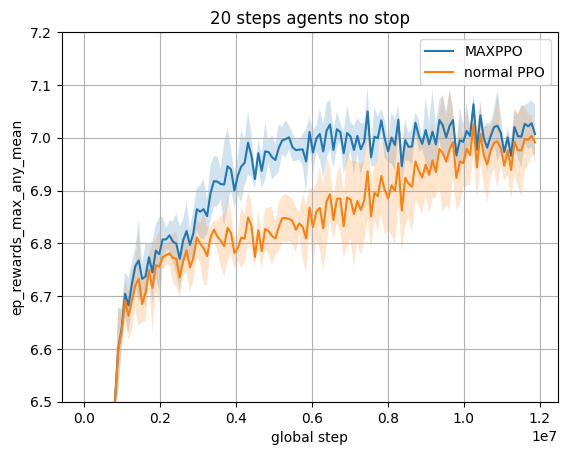

In [11]:
plot_mean_std_nice(x_axis, [all_ep_rewards_max_any_mean[0], all_ep_rewards_max_any_mean[-1]], 
                   label_list = ["MAXPPO", 
                                 "normal PPO"], 
                   ylim=(6.5, 7.2), 
                   title="20 steps agents no stop", 
                   x_label="global step", 
                   ylabel="ep_rewards_max_any_mean",
                   max_idx=max_idx)

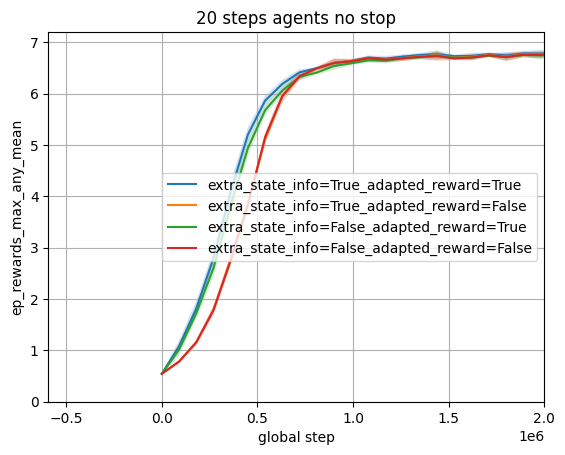

In [12]:
plot_mean_std_nice(x_axis, all_ep_rewards_max_any_mean, 
                   label_list = ["extra_state_info=True_adapted_reward=True", 
                                 "extra_state_info=True_adapted_reward=False", 
                                 "extra_state_info=False_adapted_reward=True", 
                                 "extra_state_info=False_adapted_reward=False"], 
                   ylim=(0, 7.2), 
                   xlim=(None, 2e6),
                   title="20 steps agents no stop", 
                   x_label="global step", 
                   ylabel="ep_rewards_max_any_mean",
                   max_idx=max_idx)

In [13]:
entropy_mean = -np.array([[value_dict["losses/entropy_loss"] / value_dict["ent_coeff"] for value_dict in value_dicts] 
                               for value_dicts in all_value_dicts])

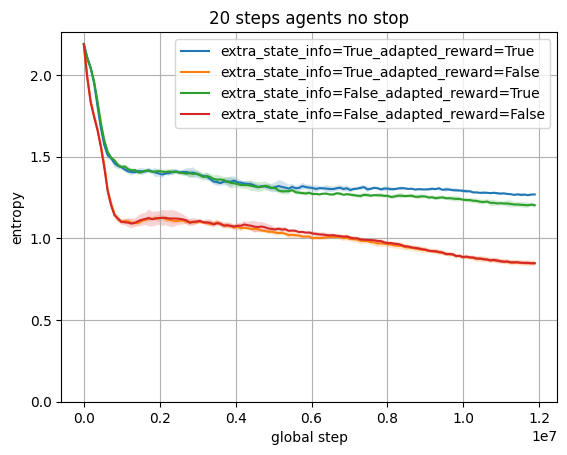

In [14]:
plot_mean_std_nice(x_axis, entropy_mean, 
                   label_list = ["extra_state_info=True_adapted_reward=True", 
                                 "extra_state_info=True_adapted_reward=False", 
                                 "extra_state_info=False_adapted_reward=True", 
                                 "extra_state_info=False_adapted_reward=False"], 
                   ylim=(0,None), 
                   title="20 steps agents no stop", 
                   x_label="global step", 
                   ylabel="entropy",
                   max_idx=max_idx)